# Hidden Markov Model on Online Retail Data

This notebook demonstrates how to load, preprocess, and analyze an online retail dataset. We will compute probability distributions and conditional probability tables (CPTs) and then build a Hidden Markov Model (HMM) to model the data. Finally, we will evaluate and visualize the model’s performance.

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from ucimlrepo import fetch_ucirepo

## Data Loading and Exploration

In this section, we load the online retail dataset from the UCI ML Repository and display some basic metadata and variable information.

In [74]:
# Fetch dataset
online_retail = fetch_ucirepo(id=352)

# Data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# Metadata and variable information
print("Metadata:")
print(online_retail.metadata)

print("\nVariable Information:")
print(online_retail.variables)

Metadata:
{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based custome

## Create DataFrame and Check for Missing Values

We convert the features into a pandas DataFrame and quickly inspect the data along with any missing values.


In [75]:
# Create DataFrame from the features
data = pd.DataFrame(online_retail.data.features)

# Display the first few rows of data
display(data)

# Check for missing values
print("\nMissing values in each column:")
print(data.isna().any())


,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...
541904,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France



Missing values in each column:
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool


## Data Preprocessing

We clean the dataset by:
- Dropping rows with missing 'Description'
- Removing rows with negative 'Quantity' and 'UnitPrice'
- Converting 'InvoiceDate' to datetime
- Dropping rows with missing 'CustomerID'
- Labelencoded 'Country'



In [76]:
# Drop rows with missing descriptions
data_clean = data.dropna(subset=['Description'])

# Remove negative Quantity and UnitPrice values (assume returns and errors)
data_clean = data_clean[(data_clean['Quantity'] > 0) & (data_clean['UnitPrice'] > 0)]

# Convert InvoiceDate to datetime
data_clean['InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'])

#Drop rows with missing ID
data_clean = data_clean.dropna(subset=['CustomerID'])


<ipython-input-76-d4e5eb34af78>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'])


In [77]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the 'Country' column
data_clean['Country'] = label_encoder.fit_transform(data_clean['Country'])

numerical_data = data_clean.select_dtypes(include=['number'])

corr_matrix = numerical_data.corr()
print(corr_matrix)

            Quantity  UnitPrice  CustomerID   Country
Quantity    1.000000  -0.004563   -0.006232 -0.012894
UnitPrice  -0.004563   1.000000   -0.010873 -0.015733
CustomerID -0.006232  -0.010873    1.000000  0.387651
Country    -0.012894  -0.015733    0.387651  1.000000


Column: Quantity


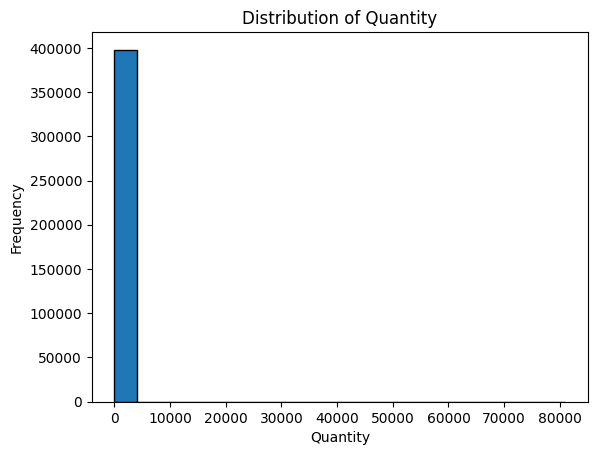

Column: UnitPrice


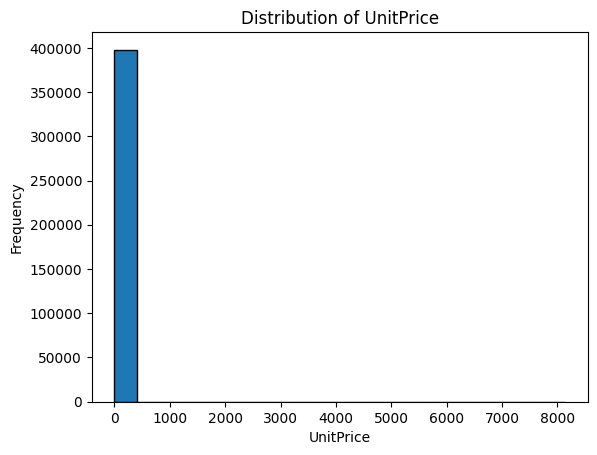

Column: CustomerID


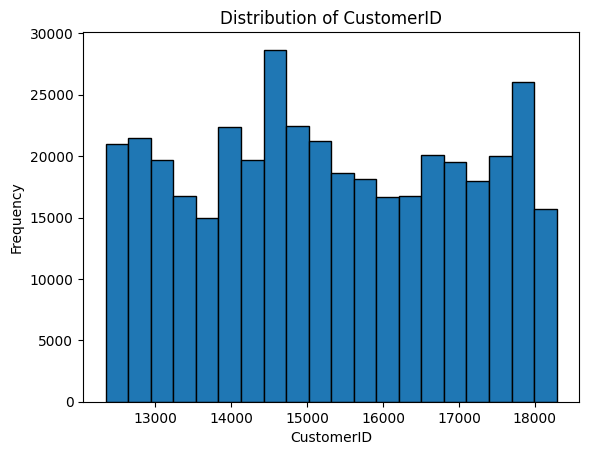

Column: Country


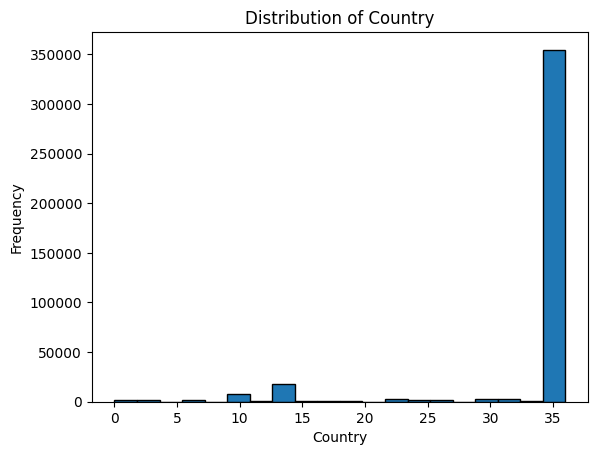

count    397884.000000
mean         12.988238
std         179.331775
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64
count    397884.000000
mean          3.116488
std          22.097877
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64
count    397884.000000
mean      15294.423453
std        1713.141560
min       12346.000000
25%       13969.000000
50%       15159.000000
75%       16795.000000
max       18287.000000
Name: CustomerID, dtype: float64
count    397884.000000
mean         32.846998
std           6.710717
min           0.000000
25%          35.000000
50%          35.000000
75%          35.000000
max          36.000000
Name: Country, dtype: float64


In [78]:
for column in numerical_data.columns:
    print(f"Column: {column}")
    plt.hist(data_clean[column], bins=20, edgecolor='k')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column}')
    plt.show()
for column in numerical_data.columns:
    # print(f"Column: {column}")
    print(numerical_data[column].describe())

## Compute Probability Distributions and Conditional Probability Tables (CPTs)

We calculate:
- Probability distributions for `Quantity`, `UnitPrice`, and `Country`
- CPTs for relationships:
  - Country vs. Quantity
  - Customer vs. Total Purchase
  - Product Description vs. Unit Price


In [79]:
# Compute probability distributions
quantity_probs = data_clean['Quantity'].value_counts(normalize=True)
unitprice_probs = data_clean['UnitPrice'].value_counts(normalize=True)
country_probs = data_clean['Country'].value_counts(normalize=True)

# Compute CPT: Given a country, what is the probability of purchasing a certain quantity?
cpt_country_quantity = data_clean.groupby('Country')['Quantity'].value_counts(normalize=True).unstack(fill_value=0)

# Compute CPT: Given a customer, what is the probability of total purchase?
data_clean['TotalPurchase'] = data_clean['Quantity'] * data_clean['UnitPrice']
cpt_customer_purchase = data_clean.groupby('CustomerID')['TotalPurchase'].sum()

# Compute CPT: Given a product description, what is the probability of its unit price?
cpt_description_price = data_clean.groupby('Description')['UnitPrice'].value_counts(normalize=True).unstack(fill_value=0)


## Feature Engineering: Quarter Calculation and Encoding

We derive a new feature 'Quarter' from the `InvoiceDate` and then encode it as numerical hidden states for our HMM.


In [80]:
# Convert quarter to numeric format: (year * 4) + quarter
data_clean['Quarter'] = data_clean['InvoiceDate'].dt.year * 4 + data_clean['InvoiceDate'].dt.quarter

# Encode quarter as hidden states
quarter_unique = np.sort(data_clean['Quarter'].unique())  # Get sorted unique quarters
quarter_mapping = {q: i for i, q in enumerate(quarter_unique)}  # Map quarters to sequential numbers
data_clean['QuarterEncoded'] = data_clean['Quarter'].map(quarter_mapping)


## Prepare Observations and Normalize Data

Here, we use the 'TotalPurchase' as our observation. We normalize these observations since it is crucial for a Gaussian HMM.


In [81]:
# Define observations: Total Purchase
data_clean['TotalPurchase'] = data_clean['Quantity'] * data_clean['UnitPrice']

# Prepare observation matrix
observations = data_clean[['TotalPurchase']].values

# Normalize the observations (important for Gaussian HMM)
scaler = StandardScaler()
observations_scaled = scaler.fit_transform(observations)

# Define hidden states based on encoded quarters
hidden_states = data_clean['QuarterEncoded'].values


## Define and Train the Hidden Markov Model

We set up a Gaussian HMM with the number of hidden states equal to the unique quarters in our dataset, then fit the model using our scaled observations.


In [69]:
# Define HMM Model
n_hidden_states = len(quarter_unique)  # Set number of hidden states equal to unique quarters
model = hmm.GaussianHMM(n_components=n_hidden_states, covariance_type="full", n_iter=1000, random_state=42)

# Fit the model on the normalized observations
model.fit(observations_scaled)

# Predict hidden states based on observations
predicted_states = model.predict(observations_scaled)


## Model Evaluation

We print the transition and emission matrices of the trained HMM and calculate the prediction accuracy by comparing the predicted hidden states to the actual quarter encoding.


In [70]:
# Print transition and emission probabilities
print("Transition Matrix:")
print(model.transmat_)

print("\nEmission Matrix (means of each state):")
print(model.means_)

# Evaluate Model Accuracy
accuracy = np.sum(predicted_states == hidden_states) / len(hidden_states)
print(f"\nPrediction Accuracy: {accuracy:.4f}")


Transition Matrix:
[[9.67214776e-001 0.00000000e+000 0.00000000e+000 1.00698980e-167
  3.27852239e-002]
 [1.86880377e-302 0.00000000e+000 0.00000000e+000 0.00000000e+000
  1.00000000e+000]
 [1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  1.50365948e-035]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  1.00000000e+000]
 [3.01177067e-001 2.56035397e-005 2.56035833e-005 2.56035789e-005
  6.98746122e-001]]

Emission Matrix (means of each state):
[[-3.48929091e-02]
 [ 5.45011962e+02]
 [ 2.49655547e+02]
 [ 1.26015209e+02]
 [ 2.96994455e-01]]

Prediction Accuracy: 0.0858


## Visualization: Hidden States Over Time

We compare the predicted hidden states against the actual quarter-encoded states by plotting them over time.


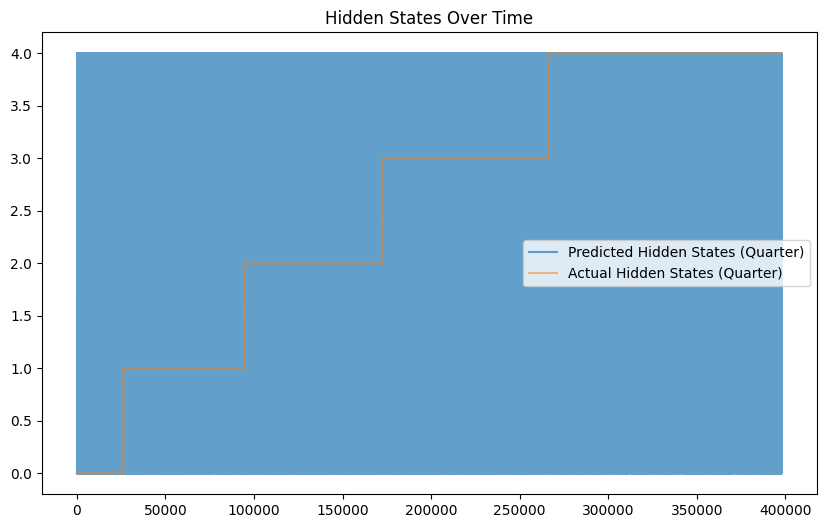

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(predicted_states, label="Predicted Hidden States (Quarter)", alpha=0.7)
plt.plot(hidden_states, label="Actual Hidden States (Quarter)", alpha=0.5)
plt.legend()
plt.title("Hidden States Over Time")
plt.show()


## Mapping Predictions to Original Quarters and Final Results

Finally, we map the predicted hidden states back to their original quarter values, display some key columns from our dataset, and print the log-likelihood of the model.


In [72]:
# Map predicted hidden states back to quarters
inverse_quarter_mapping = {v: k for k, v in quarter_mapping.items()}  # Reverse mapping
data_clean['PredictedQuarter'] = data_clean['QuarterEncoded'].map(inverse_quarter_mapping)

# Display final results
display(data_clean[['CustomerID', 'InvoiceDate', 'TotalPurchase', 'PredictedQuarter']])

# Print Log-Likelihood and reprint Accuracy
log_likelihood = model.score(observations)
print("\nLog-Likelihood:", log_likelihood)

accuracy = np.sum(hidden_states == predicted_states) / len(predicted_states)
print("Prediction Accuracy:", accuracy)


,CustomerID,InvoiceDate,TotalPurchase,PredictedQuarter
0,17850.0,2010-12-01 08:26:00,15.30,8044
1,17850.0,2010-12-01 08:26:00,20.34,8044
2,17850.0,2010-12-01 08:26:00,22.00,8044
3,17850.0,2010-12-01 08:26:00,20.34,8044
4,17850.0,2010-12-01 08:26:00,20.34,8044
...,...,...,...,...
541904,12680.0,2011-12-09 12:50:00,10.20,8048
541905,12680.0,2011-12-09 12:50:00,12.60,8048
541906,12680.0,2011-12-09 12:50:00,16.60,8048
541907,12680.0,2011-12-09 12:50:00,16.60,8048



Log-Likelihood: -40245002696.769295
Prediction Accuracy: 0.08582149571231816
